In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV as gcv
import xgboost as xgb

# Set working path
path = '/Users/martinbogaert/Desktop/NBA Data Analysis/2022-2023 Awards Project clean/'

In [2]:
data = pd.read_csv(path + 'Machine Learning/smoy/smoy_data.csv')

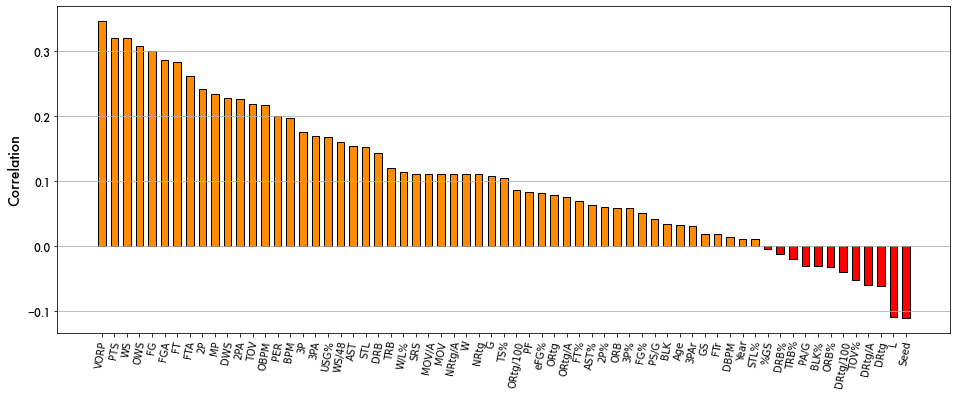

In [6]:
corr_df = data.corr().sort_values('Share', ascending = False)

plt.figure(figsize = (16, 6))

plt.bar(corr_df[corr_df['Share'] >= 0].index[1:], corr_df[corr_df['Share'] >= 0]['Share'][1:],
                        width = 0.6, color = 'darkorange', edgecolor = 'black')
plt.bar(corr_df[corr_df['Share'] < 0].index, corr_df[corr_df['Share'] < 0]['Share'],
                        width = 0.6, color = 'red', edgecolor = 'black')

#plt.plot(range(1, len(corr_df)), corr_df['Share'][1:], alpha = 0.5, linestyle = '-', c = 'black')
plt.xticks(rotation = 80)
plt.yticks(fontname = 'futura', size = 11)
plt.ylabel('Correlation', fontname = 'futura', size = 14)
plt.grid(axis = 'y')
plt.show()

In [35]:
features = ['VORP','PTS','WS','OWS','FG','MP','OBPM','PER','BPM','Seed']

In [36]:
years = np.arange(1994, 2023)
dfs = []

for year in years:
    
    print(f'Processing {year-1}-{year} season ...')
    clear_output(wait = True)
    
    X_train = data[data['Year'] < year]
    X_test = data[data['Year'] == year]
    
    model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
    model.fit(X_train[features], X_train['Share'])
    
    # Predict shares of test data
    pred = model.predict(X_test[features])
    X_test = X_test.assign(pred = pred)
    mse = mean_squared_error(pred, X_test['Share'])
    r2 = r2_score(pred, X_test['Share'])
    
    X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
    X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank
    
    X_pred = X_test.sort_values('pred').tail(1)[['Year', 'Player', 'pred', 'Rank']].rename(columns = {'Player' : 'Pred. SMOY'})
    X_test = X_test.sort_values('Share').tail(1)[['Year', 'Player', 'Share', 'Pred. rank']].rename(columns = {'Player' : 'SMOY'})
    
    dfs.append(X_test.merge(X_pred, on = 'Year').assign(mse = mse, r2 = r2))

Processing 2021-2022 season ...


In [37]:
res = pd.concat(dfs)
res['correct'] = [True if act == pred else False for act, pred in zip(res['SMOY'], res['Pred. SMOY'])]
print('Accuracy :', round(100*res['correct'].mean(), 2), '%')
print('Mean squared error :', round(100*res['mse'].mean(), 3))
print('R2-score :', round(res['r2'].mean(), 3))
res.set_index('Year')

Accuracy : 55.17 %
Mean squared error : 0.19
R2-score : -3.534


,SMOY,Share,Pred. rank,Pred. SMOY,pred,Rank,mse,r2,correct
Year,,,,,,,,,
1994,Dell Curry,0.455,3,Dennis Rodman,0.297482,6,0.002150,-2.752625,False
1995,Anthony Mason,0.448,2,Sam Perkins,0.206761,10,0.001139,-2.023806,False
1996,Toni Kukoč,0.398,1,Toni Kukoč,0.338739,1,0.000239,0.770081,True
1997,John Starks,0.730,7,Bo Outlaw,0.110166,7,0.002591,-13.082183,False
1998,Danny Manning,0.491,3,Dana Barros,0.104585,8,0.001461,-9.799330,False
1999,Darrell Armstrong,0.720,1,Darrell Armstrong,0.234491,1,0.001430,-3.196310,True
2000,Rodney Rogers,0.860,2,Tracy McGrady,0.230825,3,0.002520,-4.638476,False
2001,Aaron McKie,0.460,4,Donyell Marshall,0.192071,9,0.001292,-2.084365,False
2002,Corliss Williamson,0.448,4,Robert Horry,0.067889,8,0.001218,-21.212925,False


In [88]:
X_train = data[data['Year'] < 2022]
X_test = data[data['Year'] == 2022]

model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
model.fit(X_train[features], X_train['Share'])

# Predict shares of test data
pred = model.predict(X_test[features])
X_test = X_test.assign(pred = pred)

X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank

In [89]:
res_2022 = X_test.sort_values('Pred. rank')[['Player','Tm','Share', 'Rank', 'Pred. rank','pred']]

In [90]:
tm_col = {'ATL': '#e03a3e', 'BOS': 'green','BRK': 'gray','CHI': '#ce1141','CHO': 'aqua','CLE': 'maroon','DAL': 'cornflowerblue',
          'DEN': 'indigo','DET': 'royalblue','GSW': 'gold','HOU': 'lightcoral','IND': 'yellow','LAC': 'silver','LAL': '#fdb927','MEM': 'skyblue','MIA': 'hotpink',
          'MIL': '#00471b','MIN': 'lime','NOP': 'goldenrod','NYK': 'darkorange','OKC': 'dodgerblue','ORL': 'navy',
          'PHI': 'blue','PHO': 'orange','POR': '#cf0a2c','SAC': 'mediumslateblue','SAS': 'white','TOR': 'purple',
          'UTA': 'forestgreen','WAS': 'midnightblue'}

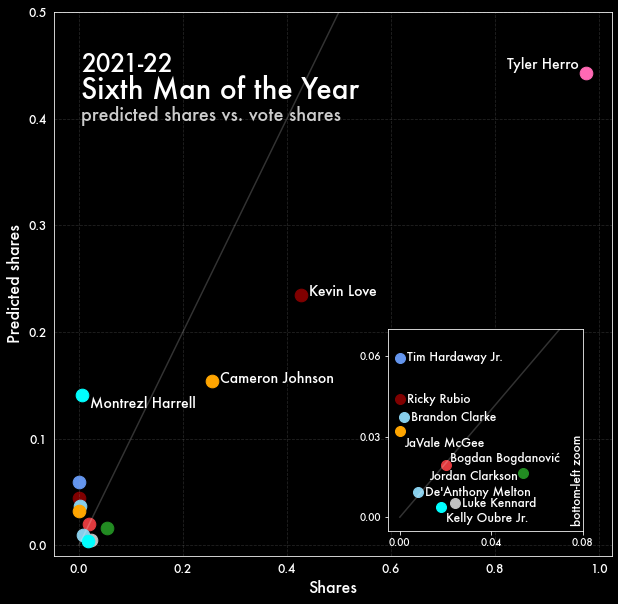

In [140]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = 'black')

plt.plot([0, max(res_2022['Share'].max(), res_2022['pred'].max())], [0, max(res_2022['Share'].max(), res_2022['pred'].max())], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if pred > 0.02 or share > 0.007:
        plt.scatter(share, pred, c = tm_col.get(tm), s = 160)
        
        if player == 'Tyler Herro':
            plt.annotate(player, xy = (share - 0.015, pred), fontname = 'futura', color = 'white', size = 14, va = 'bottom', ha = 'right')
            
        elif player == 'Montrezl Harrell':
            plt.annotate(player, xy = (share + 0.015, pred), fontname = 'futura', color = 'white', size = 14, va = 'top', ha = 'left')

        elif pred > 0.1 or share > 0.2 :
            plt.annotate(player, xy = (share + 0.015, pred - 0.005), fontname = 'futura', color = 'white', size = 14, va = 'bottom')
      
plt.ylabel('Predicted shares', color = 'white', size = 16, fontname = 'futura')
plt.xlabel('Shares', color = 'white', size = 16, fontname = 'futura')
plt.xticks(color = 'white', fontname = 'futura', size = 12)
plt.yticks(color = 'white', fontname = 'futura', size = 12)
plt.grid(linestyle = '--', alpha = 0.2)

### ANNOTATION ###
# Title
plt.annotate('2021-22', xy = (1/20, 0.89), fontname = 'futura', size = 24, xycoords = 'axes fraction', weight = 'bold', color = 'white') 
plt.annotate('Sixth Man of the Year', xy = (1/20, 0.84), fontname = 'futura', size = 28, xycoords = 'axes fraction', weight = 'bold', color = 'white')
# Sub-title
plt.annotate('predicted shares vs. vote shares', xy = (1/20, 0.8), fontname = 'futura', size = 18, xycoords = 'axes fraction', color = 'white', alpha = 0.8)
# Signature
#plt.annotate('@      .', xy = (0.875, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = 'white')
#plt.annotate('nba', xy = (0.9, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff9000')
#plt.annotate('ai', xy = (0.95, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff58c4')

ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white')
ax_gca = plt.gca()
plt.ylim([-0.01,0.5])
ax_gca.set_facecolor('black')

########

newax = fig.add_axes([0.59,0.16,0.27,0.28], zorder = 1)
newax.plot([0, 0.2], [0, 0.2], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if share < 0.2 and pred < 0.2 :
        if share > 0.007 or pred > 0.02 :
            newax.scatter(share, pred, c = tm_col.get(tm), s = 100)
            
            if player == 'Bogdan Bogdanović' or player == "f" or player == 'Kevin Durant' or player == 'Jimmy Butler' :
                newax.annotate(player, xy = (share+0.002, pred), fontname = 'futura', color = 'white', size = 12, va = 'bottom')
            elif player == 'Jordan Clarkson' :
                newax.annotate(player, xy = (share-0.0025, pred+0.001), fontname = 'futura', color = 'white', size = 12, va = 'top', ha = 'right')
            elif player == 'Kelly Oubre Jr.' or player == 'JaVale McGee':
                newax.annotate(player, xy = (share+0.002, pred-0.002), fontname = 'futura', color = 'white', size = 12, va = 'top')
            else :
                newax.annotate(player, xy = (share+0.003, pred), fontname = 'futura', color = 'white', size = 12, va = 'center')

newax.set_xticks([0, 0.04, 0.08])
newax.set_yticks([0, 0.03, 0.06])
newax.tick_params(colors = 'white')

labels = newax.get_xticklabels() + newax.get_yticklabels()
[label.set_fontname('futura') for label in labels]

newax.annotate('bottom-left zoom', xy = (0.94, 1/25), fontname = 'futura', size = 12, xycoords = 'axes fraction', color = 'white', rotation = 90) 
newax.spines['left'].set_color('white'); newax.spines['right'].set_color('white')
newax.spines['bottom'].set_color('white'); newax.spines['top'].set_color('white')
newax.set_xlim([-0.005, 0.08]); newax.set_ylim([-0.005, 0.07])
ax_gca = plt.gca()
ax_gca.set_facecolor('black')

#plt.savefig(path + 'smoy_2022_test.jpg', dpi = 300)
plt.show()

In [128]:
res_2022.sort_values('Rank').head(15)

,Player,Tm,Share,Rank,Pred. rank,pred
7813,Tyler Herro,MIA,0.976,1,1,0.442623
7864,Kevin Love,CLE,0.428,2,2,0.235081
7627,Cameron Johnson,PHO,0.256,3,3,0.153684
7845,Jordan Clarkson,UTA,0.054,4,12,0.016381
7717,Luke Kennard,LAC,0.024,5,19,0.005160
7832,Bogdan Bogdanović,ATL,0.020,6,9,0.019396
7799,Kelly Oubre Jr.,CHO,0.018,7,23,0.003919
7852,De'Anthony Melton,MEM,0.008,8,14,0.009402
7800,Montrezl Harrell,CHO,0.006,9,4,0.140542
7680,Immanuel Quickley,NYK,0.004,10,33,0.003071
